Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Set seed for reproducibility
np.random.seed(123)

# Load data
train = pd.read_csv('../CW1_train.csv')
X_test_final = pd.read_csv('../CW1_test.csv')

y = train.iloc[:, 0]
X = train.iloc[:, 1:]

Exploratory Data Analysis

Explicit missing values:
 outcome    0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
a1         0
a2         0
a3         0
a4         0
a5         0
b1         0
b2         0
b3         0
b4         0
b5         0
a6         0
a7         0
a8         0
a9         0
a10        0
b6         0
b7         0
b8         0
b9         0
b10        0
dtype: int64

Zero values in x, y, z (physically impossible):
 x    2
y    2
z    4
dtype: int64


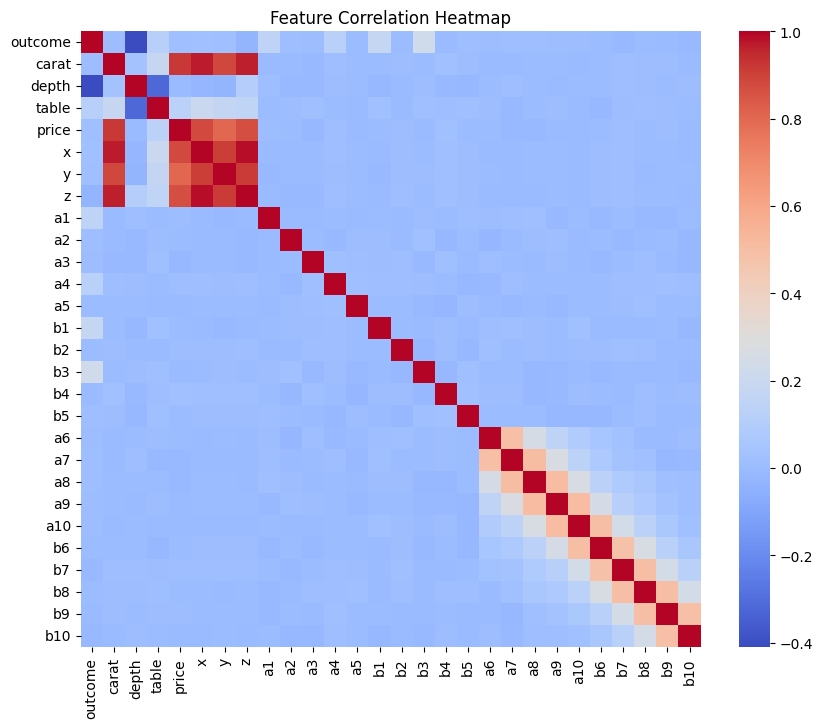

In [ ]:
# check for missing values
print("Explicit missing values:\n", train.isnull().sum())

# Check for "hidden" missing values (Zeros in physical dimensions)
zeros = (train[['x', 'y', 'z']] == 0).sum()
print("\nZero values in x, y, z (physically impossible):\n", zeros)

# Initial Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train.select_dtypes(include=[np.number]).corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

Feature Engineering and Preprocessing

In [ ]:
def preprocess(df):
    # volume feature engineering
    df['volume'] = df['x'] * df['y'] * df['z']
    df = df.drop(columns=['x', 'y', 'z'])
    # robust median imputation for zeroes & missing values
    df = df.fillna(df.median(numeric_only=True))
    # categorical Encoding
    df = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)
    return df

X_processed = preprocess(X)
X_test_processed = preprocess(X_test_final)

# ensures test set matches training set features
X_test_processed = X_test_processed.reindex(columns=X_processed.columns, fill_value=0)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=123)

Model Selection

Linear Regression R2: 0.2803
Random Forest R2: 0.4491
XGBoost (Default) R2: 0.3880


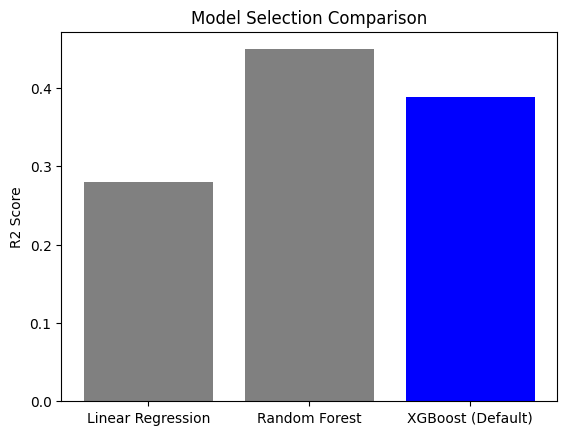

In [5]:
model_comparison = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123),
    "XGBoost (Default)": XGBRegressor(random_state=123)
}

results = {}
for name, mod in model_comparison.items():
    cv_score = cross_val_score(mod, X_train, y_train, cv=5, scoring='r2').mean()
    results[name] = cv_score
    print(f"{name} R2: {cv_score:.4f}")

# Plotting Comparison
plt.bar(results.keys(), results.values(), color=['grey', 'grey', 'blue'])
plt.ylabel('R2 Score')
plt.title('Model Selection Comparison')
plt.show()

Hyperparameter Optimisation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the search space
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=123, objective='reg:squarederror', eval_metric='rmse'),
    param_distributions=param_grid,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=123
)

xgb_search.fit(X_train, y_train)
print(f"Best Parameters: {xgb_search.best_params_}")
print(f"Best Search Score: {xgb_search.best_score_:.4f}")

# extract the final best model
best_model = xgb_search.best_estimator_

Starting Randomized Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best Search Score: 0.4696


In [ ]:
print("Final Model Parameters:")
print(best_model.get_params())

print(f"\nSpecific n_estimators used: {best_model.n_estimators}")
print(f"Specific max_depth used: {best_model.max_depth}")

Final Model Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 123, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

Specific n_estimators used: 500
Specific max_depth use

Model Training and Learning

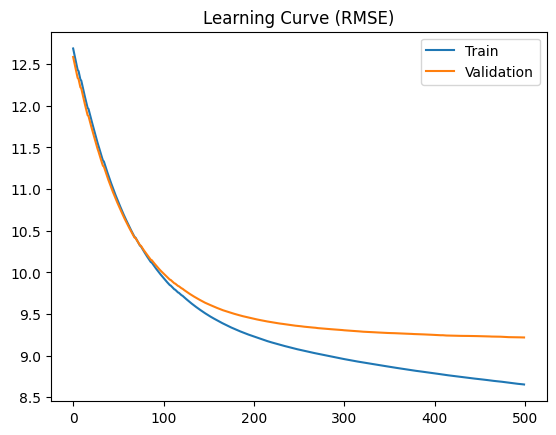

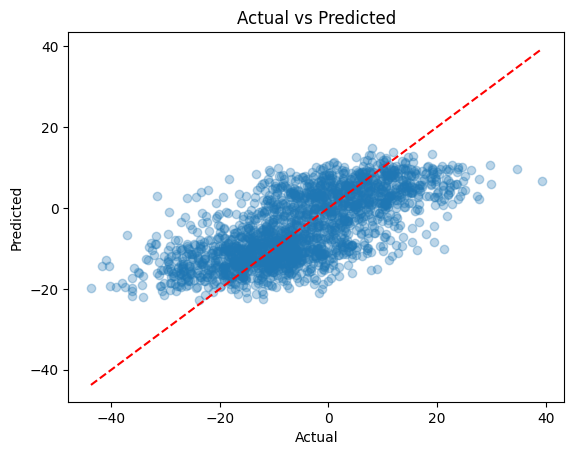

In [ ]:
# Learning Curve
# helps me see if 1000 estimators was enough or too many
eval_set = [(X_train, y_train), (X_val, y_val)]
best_model.fit(X_train, y_train,  eval_set=eval_set, verbose=False)
results = best_model.evals_result()

plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Validation')
plt.title("Learning Curve (RMSE)")
plt.legend()
plt.show()

# Actual vs Predicted
preds = best_model.predict(X_val)
plt.scatter(y_val, preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

FInal Model Comparison

In [8]:
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

Final Model Comparison (Mean R2 across 5-folds):
Linear Regression
(Baseline): 0.2859
Random Forest
(Default): 0.4502
XGBoost
(Optimized): 0.4732


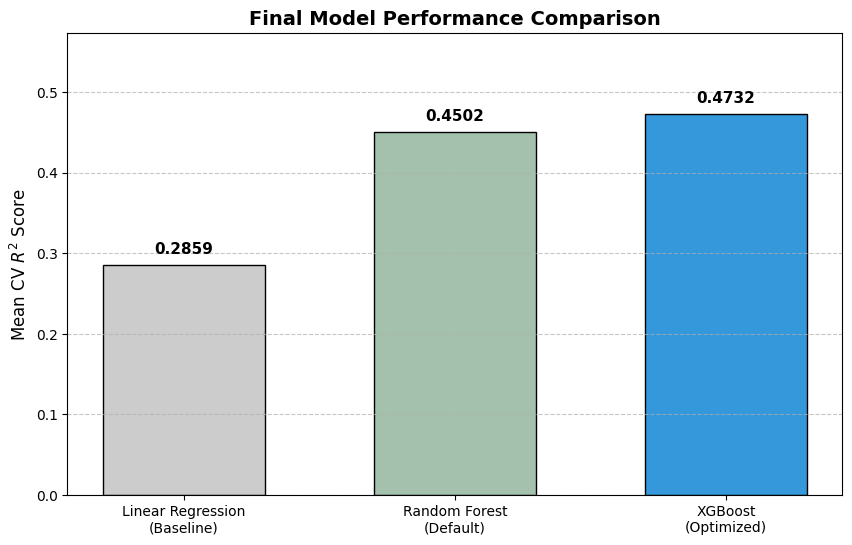

In [ ]:
# using best model
final_comparison = {
    "Linear Regression\n(Baseline)": LinearRegression(),
    "Random Forest\n(Default)": RandomForestRegressor(random_state=123),
    "XGBoost\n(Optimized)": best_model 
}

print("Final Model Comparison (Mean R2 across 5-folds):")
final_results = {}

for name, model in final_comparison.items():
    # Using cross-validation 
    cv_scores = cross_val_score(model, X_processed, y, cv=5, scoring='r2')
    mean_score = cv_scores.mean()
    final_results[name] = mean_score
    print(f"{name}: {mean_score:.4f}")

plt.figure(figsize=(10, 6))

colors = ['#cccccc', '#a3c1ad', '#3498db'] 

bars = plt.bar(final_results.keys(), final_results.values(), color=colors, edgecolor='black', width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Mean CV $R^2$ Score', fontsize=12)
plt.title('Final Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, max(final_results.values()) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# saved for latex report
plt.savefig('figures/model_comparison_final.png', bbox_inches='tight')
plt.show()